In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn import svm
from sklearn import mixture
from sklearn.metrics import confusion_matrix
import glob

abdullah_training_directory = './images/Abdullah/training/'
mustafa_training_directory = './images/Mustafa/training/'
saleh_training_directory = './images/Saleh/training/'
adham_training_directory = './images/Adham/training/'

abdullah_testing_directory = './images/Abdullah/testing/'
mustafa_testing_directory = './images/Mustafa/testing/'
saleh_testing_directory = './images/Saleh/testing/'
adham_testing_directory = './images/Adham/testing/'


training_images_directories = [abdullah_training_directory, mustafa_training_directory, saleh_training_directory, adham_training_directory]
testing_images_directories = [abdullah_testing_directory, mustafa_testing_directory, saleh_testing_directory, adham_testing_directory]

training_images = []
testing_images = []

# Load the cascade for facial detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# Populate Training Image list
for directory in training_images_directories:
    images = [cv2.imread(file) for file in glob.glob("{directory}*.jpg".format(directory=directory))]
    for img in images:
        training_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
# Populate Testing Image list
for directory in testing_images_directories:
    images = [cv2.imread(file) for file in glob.glob("{directory}*.jpg".format(directory=directory))]
    for img in images:
        testing_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

"""
4.1 + 4.3 --- Training Images Feature Extraction using SIFT
"""

# create a SIFT object
sift = cv2.xfeatures2d.SIFT_create()

training_bounds = []

plt.figure(figsize=(20, 80))
for i in range(60):
    img = training_images[i]
    # copy image
    img_disp = img.copy()
    # convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # detect harris corners
    # cv2.cornerHarris(src, neighborhoodsize, sobelKernelSize, Harris_k)
    corners = cv2.cornerHarris(img_gray, 2, 3, 0.04)

    # normalize corner map [0,1]
    # cv2.normalize(src, dst, alpha, beta, norm_type)
    # min_I(dst(I)) = alpha, max_I(dst(I)) = beta
    cv2.normalize(corners, corners, 0, 1, cv2.NORM_MINMAX)

    # threshold for an optimal value
    thres = 0.5

    # list all points higher than threshold
    loc = np.where(corners >= thres)
    # loop though points
    
    pts = []
    
    for pt in zip(*loc[::-1]):
        pts.append(pt)
        
        # draw filled circle on each point
        cv2.circle(img_disp, pt, 4, (255,0,0), -1)

    xs, ys = np.array(list(zip(*pts)))
    bounds_dict = {"min_x" : np.amin(xs), "min_y" : np.amin(ys), "max_x" : np.amax(xs), "max_y" : np.amax(ys)}
    training_bounds.append(bounds_dict)
    
    # display images
    plt.subplot(15, 4, (math.floor(i/15) + 1 + 4*(i%15))), plt.imshow(img_disp)
    
plt.show()

<Figure size 2000x8000 with 60 Axes>

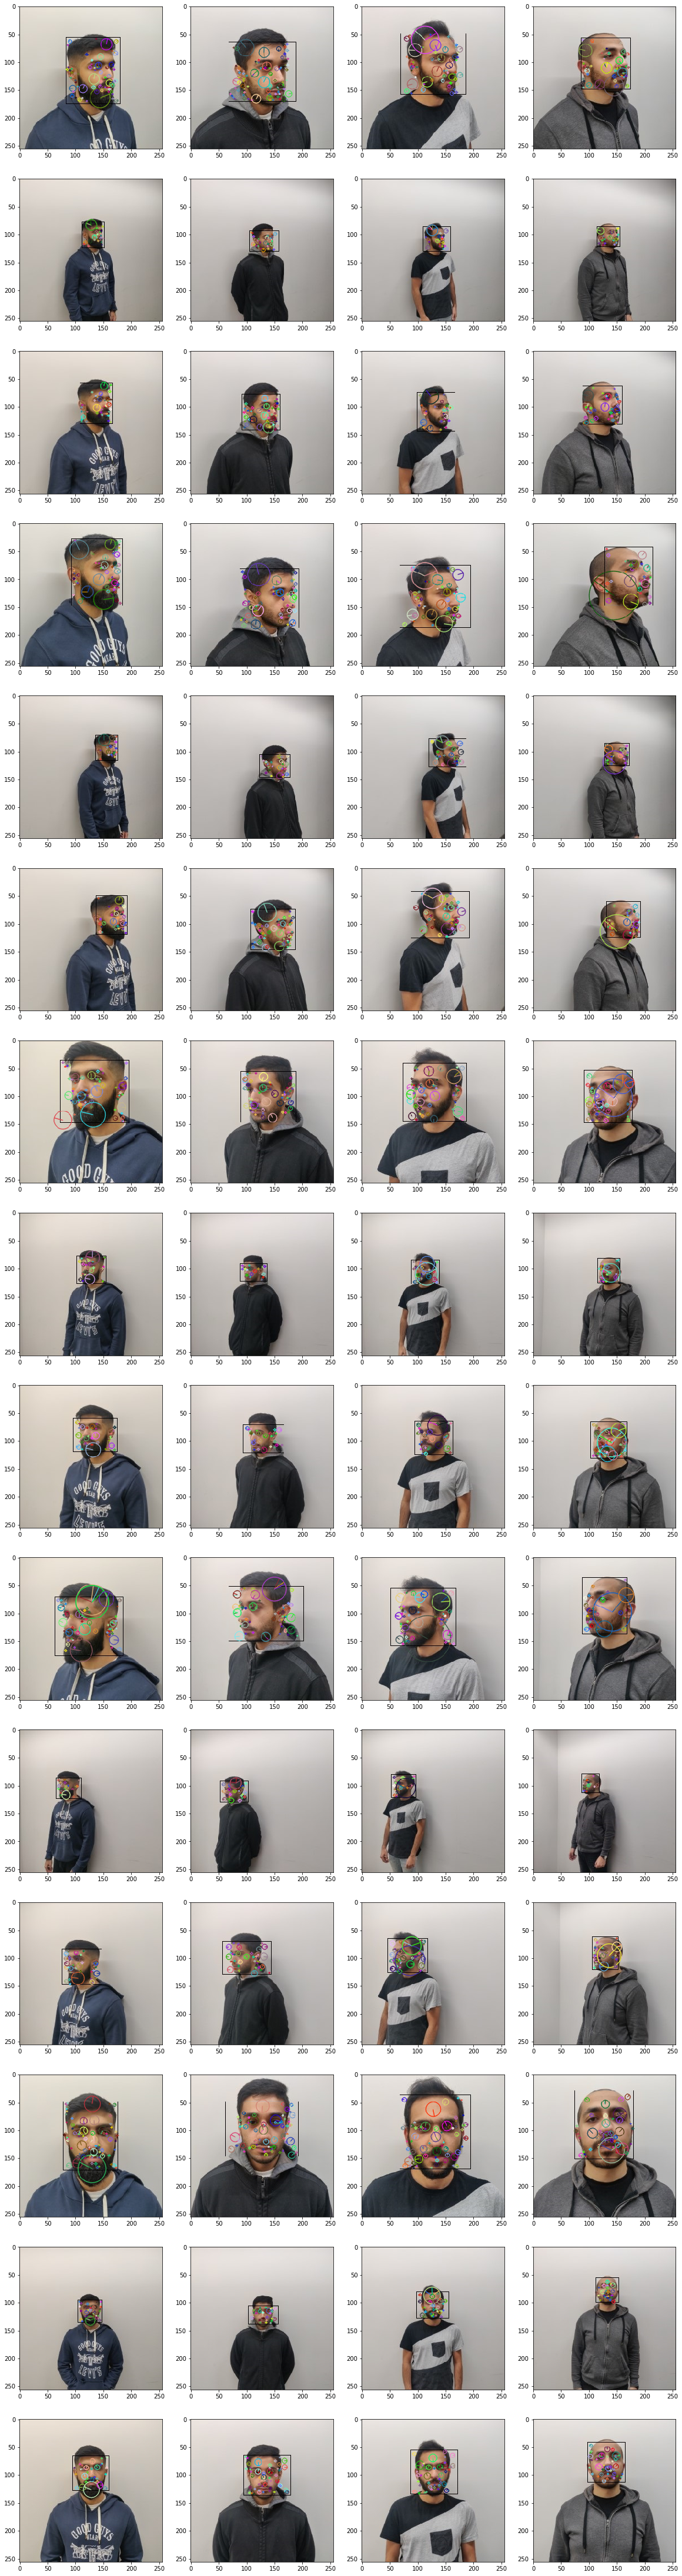

In [11]:
training_descriptors = []

plt.figure(figsize=(20, 80))
for i in range(60):
    img = training_images[i]
    
    img_disp = img.copy()

    # create a SIFT object
    sift = cv2.xfeatures2d.SIFT_create()

    # detect SIFT features, with no masks
    keypoints = sift.detect(img, None)

    keypoints_filtered = []
    for kp in keypoints:
        point = kp.pt;
        if(point[0] > training_bounds[i]["min_x"] and point[0] < training_bounds[i]["max_x"] 
           and point[1] > training_bounds[i]["min_y"] and point[1] < training_bounds[i]["max_y"]):
            keypoints_filtered.append(kp)
    
    keypoints = keypoints_filtered

    # compute SIFT descriptors
    keypoints, descriptors = sift.compute(img, keypoints)
    
    clf = mixture.GaussianMixture(n_components=3, covariance_type='full')

    # fit GMM on train data
    clf.fit(descriptors)

    # predict cluster membership from the fitted GMM 
    labels = clf.predict(descriptors)
    
    descriptors_labels = {"descriptors" : descriptors, "labels" : labels}
    
    training_descriptors.append(descriptors_labels)
    
    # draw the keypoints
    cv2.drawKeypoints(img, keypoints, img_disp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # display images
    plt.subplot(15, 4, (math.floor(i/15) + 1 + 4*(i%15))), plt.imshow(img_disp)
    
    
    
plt.show()